# EX: Retrieval from Digital Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import chromadb
import subprocess
import os
from langchain.document_loaders import DirectoryLoader
from langchain.document_loaders import UnstructuredPDFLoader
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain.llms import LlamaCpp
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.prompts import PromptTemplate
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.chains.question_answering import load_qa_chain
from langchain.output_parsers import CommaSeparatedListOutputParser
from semantic_router.layer import RouteLayer
from langchain.chains import ConversationChain
from langchain.prompts import PromptTemplate
from langchain_core.prompts.prompt import PromptTemplate
from langchain.docstore.document import Document
from langchain_chroma import Chroma
from langchain_community.document_loaders import TextLoader
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)
from langchain_text_splitters import CharacterTextSplitter


#BERTscore
import bert_score
import logging
import transformers
transformers.tokenization_utils.logger.setLevel(logging.ERROR)
transformers.configuration_utils.logger.setLevel(logging.ERROR)
transformers.modeling_utils.logger.setLevel(logging.ERROR)
from bert_score import BERTScorer
from BRAD import brad
from BRAD import rag

In [2]:
# Load results from experiment
dfQ   = pd.read_csv('EX-10-June-2024-Qs.csv')
dfLLM = pd.read_csv('EX-10-JUNE-2024-LLM-llama3-70b.csv')
dfRAG = pd.read_csv('EX-10-JUNE-2024-RAG-llama3-70b.csv')

In [3]:
# Load the database
persist_directory = '/nfs/turbo/umms-indikar/shared/projects/RAG/databases/DigitalLibrary-10-June-2024/'
embeddings_model = HuggingFaceEmbeddings(model_name='BAAI/bge-base-en-v1.5')
db_name = "DigitalLibrary"
_client_settings = chromadb.PersistentClient(path=(persist_directory + db_name))
vectordb = Chroma(persist_directory=persist_directory, embedding_function=embeddings_model, client=_client_settings, collection_name=db_name)

Tue Jun 11 16:24:20 2024 INFO Use pytorch device_name: cpu
Tue Jun 11 16:24:20 2024 INFO Load pretrained SentenceTransformer: BAAI/bge-base-en-v1.5
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Tue Jun 11 16:24:23 2024 INFO Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
Tue Jun 11 16:24:23 2024 INFO Collection DigitalLibrary is not created.


# QA

## What is the distribution of prompt-doc similarity over all questions?

In [28]:
numeric_df = dfRAG.select_dtypes(include=['int64', 'float64'])
similarityScores = numeric_df.values.reshape(-1)
meanSimilarity = np.mean(numeric_df.values, axis=1)

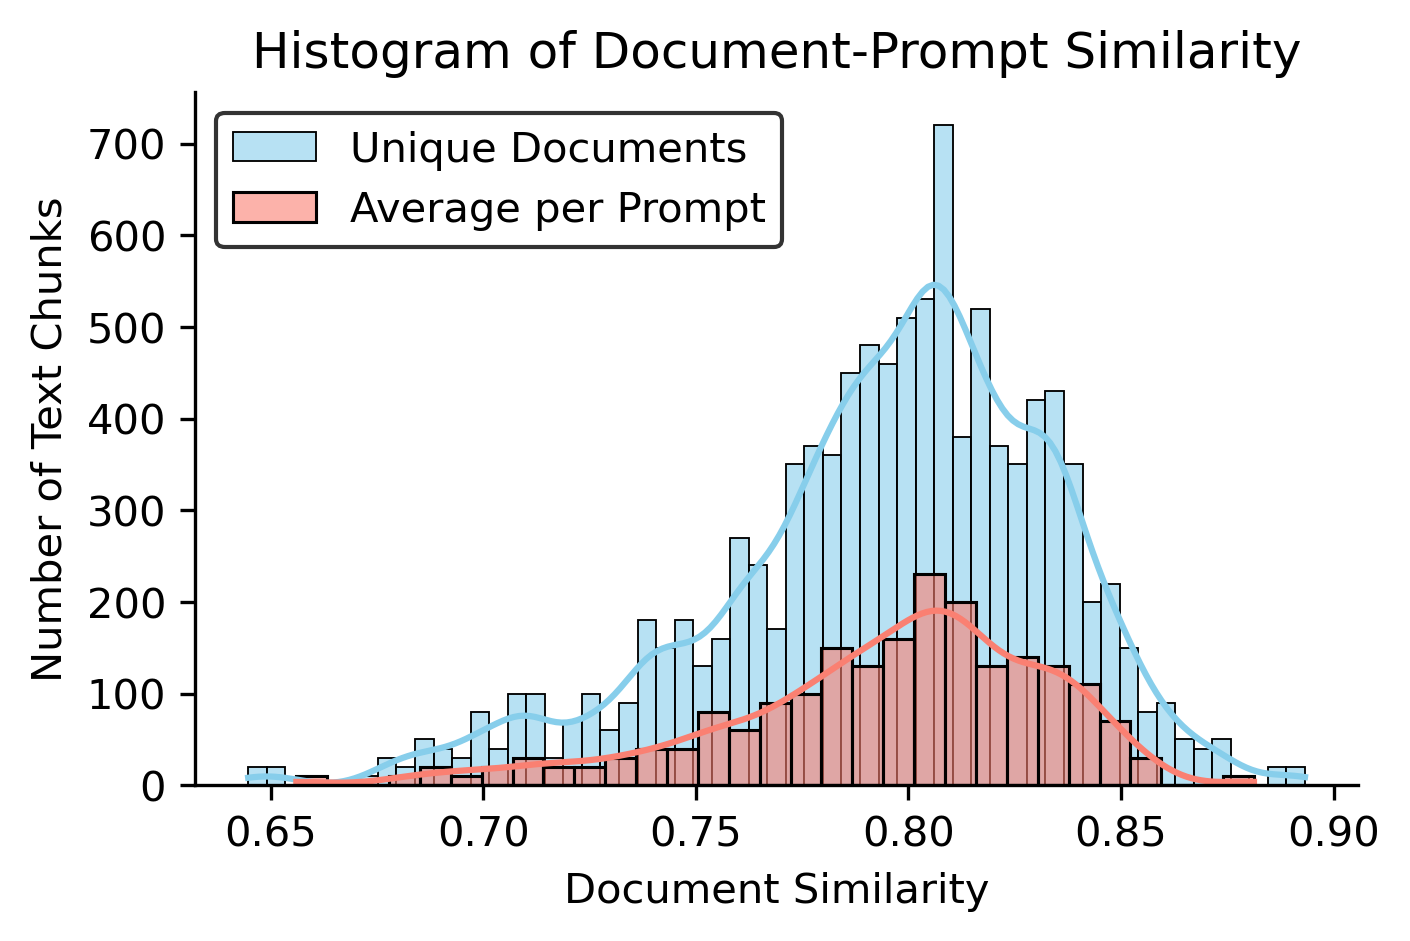

In [29]:
plt.figure(figsize=(5, 3), dpi=300)
sns.histplot(similarityScores, label='Unique Documents', kde=True, color='skyblue', alpha=0.6)
sns.histplot(meanSimilarity, label='Average per Prompt', kde=True, color='salmon', alpha=0.6)

# Remove the top and right spines
sns.despine()

# Add labels and title
plt.xlabel('Document Similarity')
plt.ylabel('Number of Text Chunks')
plt.title('Histogram of Document-Prompt Similarity')

# Add a legend
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_edgecolor('black')
frame.set_facecolor('white')

# Display the plot
plt.show()


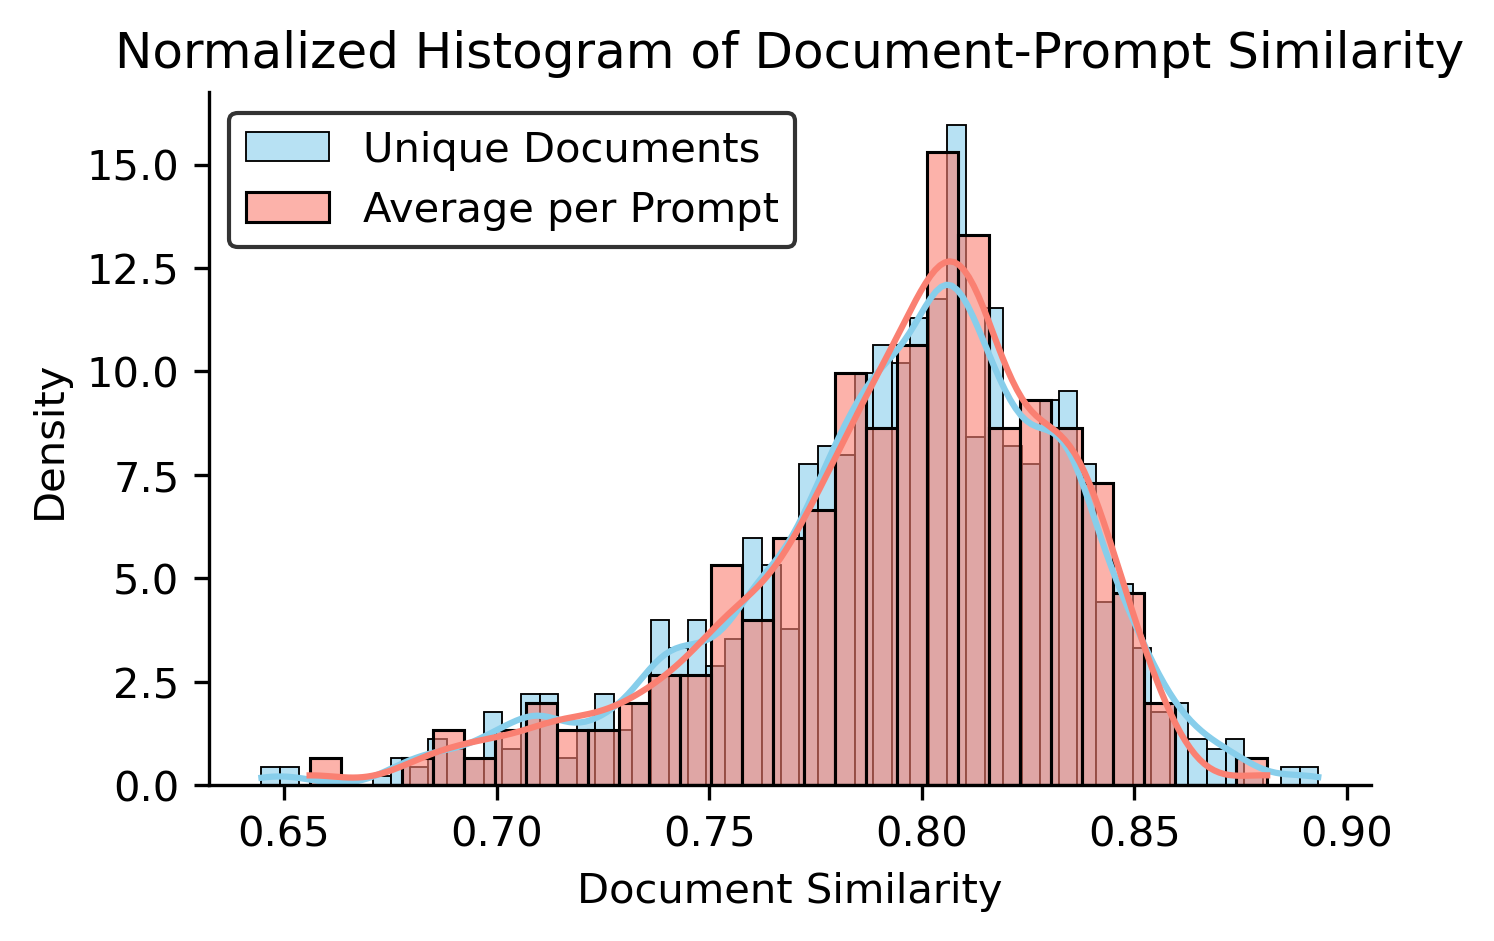

In [31]:
plt.figure(figsize=(5, 3), dpi=300)
sns.histplot(similarityScores, label='Unique Documents', kde=True, color='skyblue', alpha=0.6, stat='density')
sns.histplot(meanSimilarity, label='Average per Prompt', kde=True, color='salmon', alpha=0.6, stat='density')

# Remove the top and right spines
sns.despine()

# Add labels and title
plt.xlabel('Document Similarity')
plt.ylabel('Density')
plt.title('Normalized Histogram of Document-Prompt Similarity')

# Add a legend
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_edgecolor('black')
frame.set_facecolor('white')

# Display the plot
plt.show()


## What is the distribution in variance of doc-prompt similarity

In [59]:
numeric_df = dfRAG.select_dtypes(include=['int64', 'float64'])
similarityScores = np.std(numeric_df.values, axis=1)

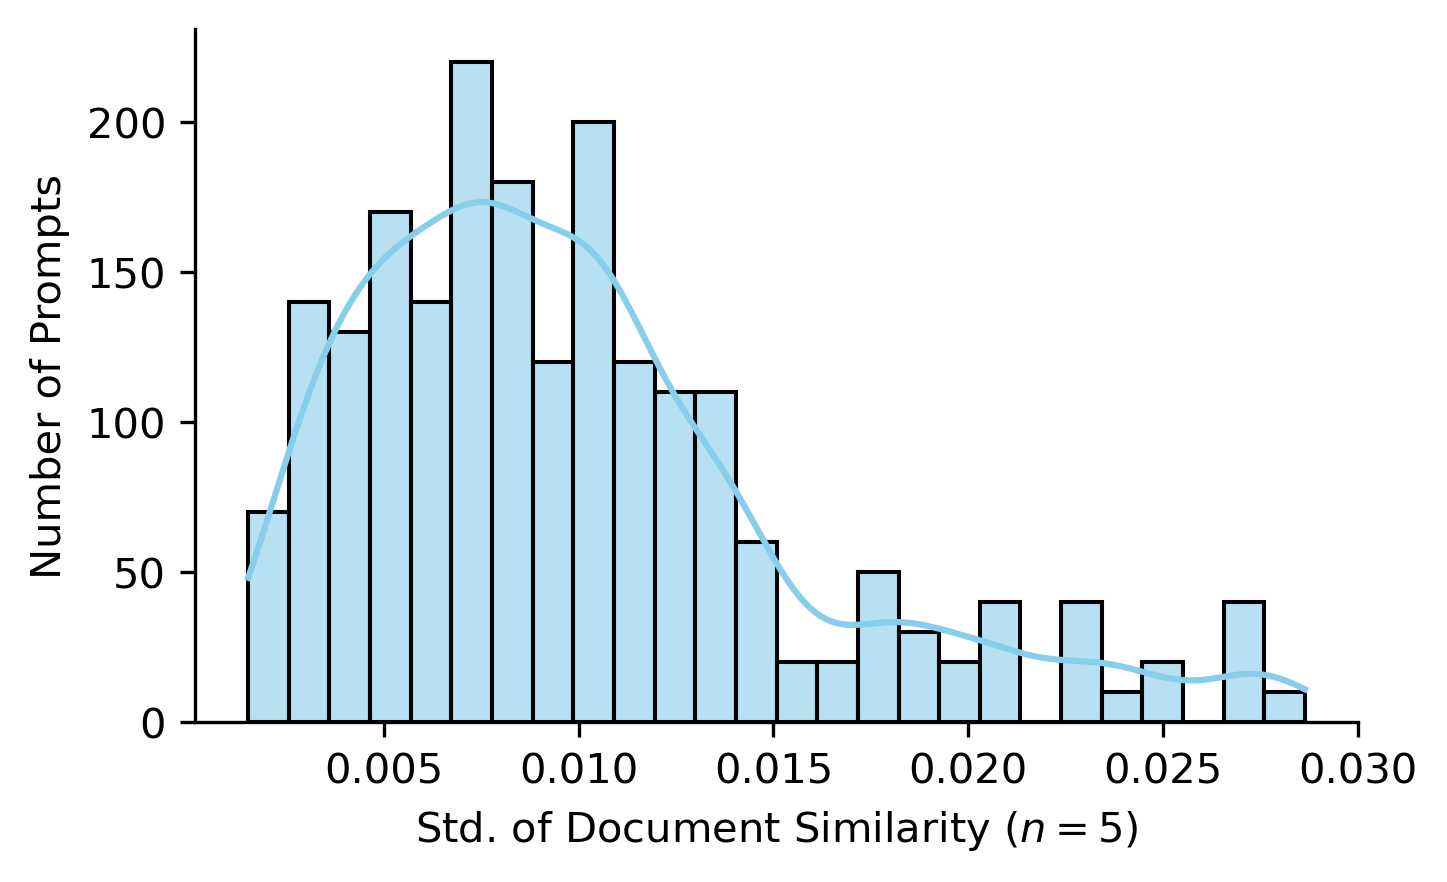

In [69]:
plt.figure(figsize=(5, 3), dpi=300)
sns.histplot(similarityScores, label='Unique Documents', kde=True, color='skyblue', alpha=0.6)

# Remove the top and right spines
sns.despine()

# Add labels and title
plt.xlabel('Std. of Document Similarity ($n=5$)')
plt.ylabel('Number of Prompts')

# Add a legend
#legend = plt.legend(frameon=True)
#frame = legend.get_frame()
#frame.set_edgecolor('black')
#frame.set_facecolor('white')

# Display the plot
plt.show()


## How does the similarity distribution change as the number of documents change?

In [48]:
scores = []
numDocs = 1000
for i, prompt in enumerate(dfQ['Question']):
    print(str(i) + ': ' + prompt)
    documentSearch = vectordb.similarity_search_with_relevance_scores(prompt, k=numDocs)
    _, docScores      = rag.getDocumentSimilarity(documentSearch)
    scores.append(docScores)
scores = np.array(scores)

0: Gene regulation is often described from the perspective of a dynamical system, where gene expression or other measures are used to construct a state space model. In deterministic dynamical systems, the state variable contains sufficient information to determine the future of the system. What experimental measurements do you believe are sufficient to determine the state of a cell?
1: Compare and contrast the utility of dynamical systems and control theory perspectives relative to machine learning models of cellular reprogramming. What are the advantages and disadvantages of each perspective and which data are utilized in each framework?
2: Synthetic lethality occurs when the knockout of two genes is lethal to a cell while the knockout of either gene separately would not kill the cell. The Yeast-2-Hybrid assay is an experimental technique that can determine if two proteins bind with one another by transplanting the proteins to a yeast cell and attaching them to reporter genes. Are the

### Mean

In [8]:
meanScores = np.mean(scores, axis=1)

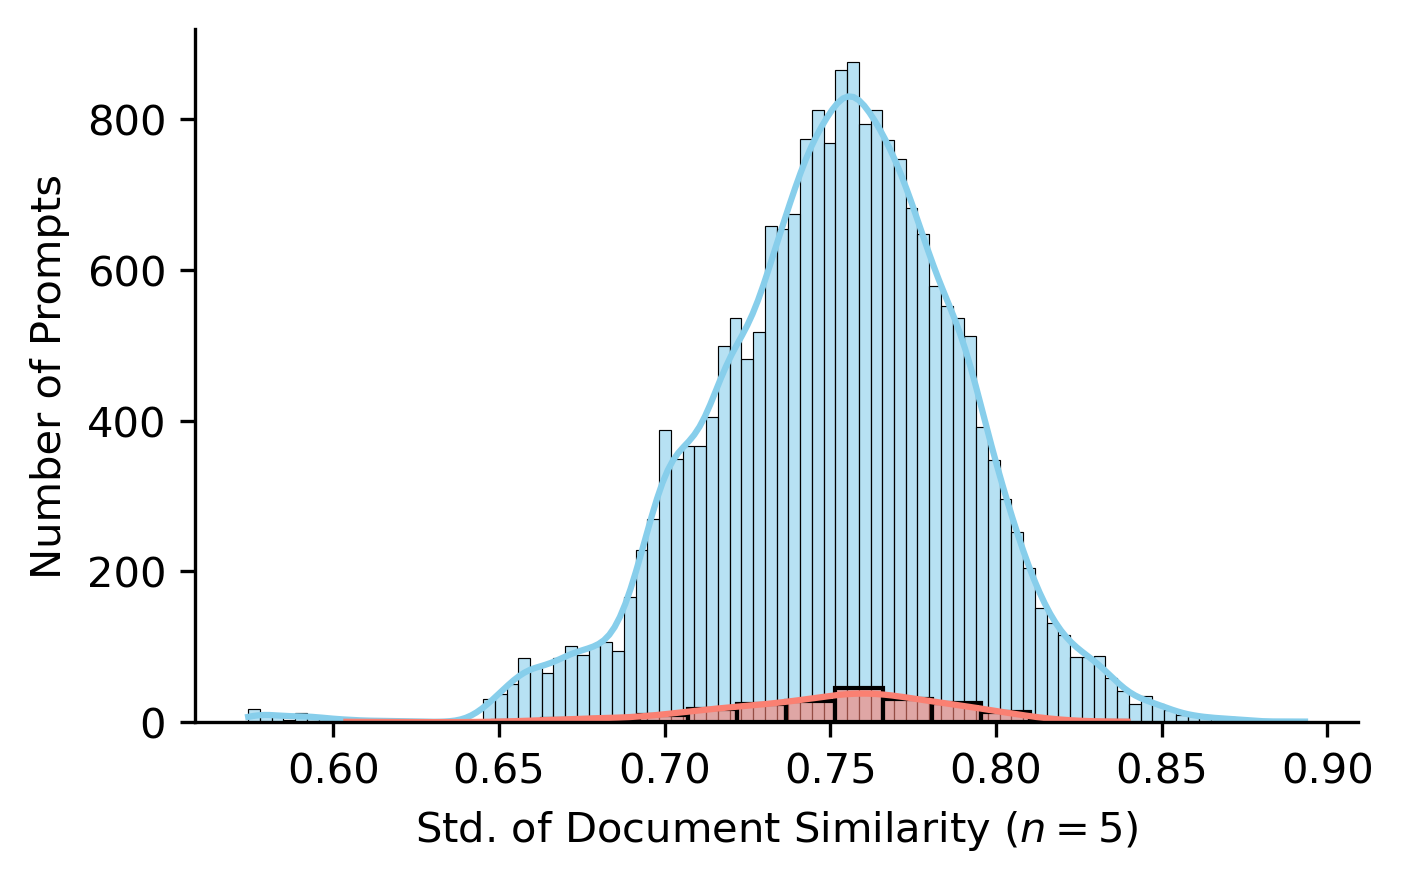

In [10]:
plt.figure(figsize=(5, 3), dpi=300)
sns.histplot(scores.reshape(-1), label='Unique Documents', kde=True, color='skyblue', alpha=0.6)
sns.histplot(meanScores,         label='Prompts', kde=True, color='salmon', alpha=0.6)

# Remove the top and right spines
sns.despine()

# Add labels and title
plt.xlabel('Std. of Document Similarity ($n=5$)')
plt.ylabel('Number of Prompts')

# Display the plot
plt.show()


### STD

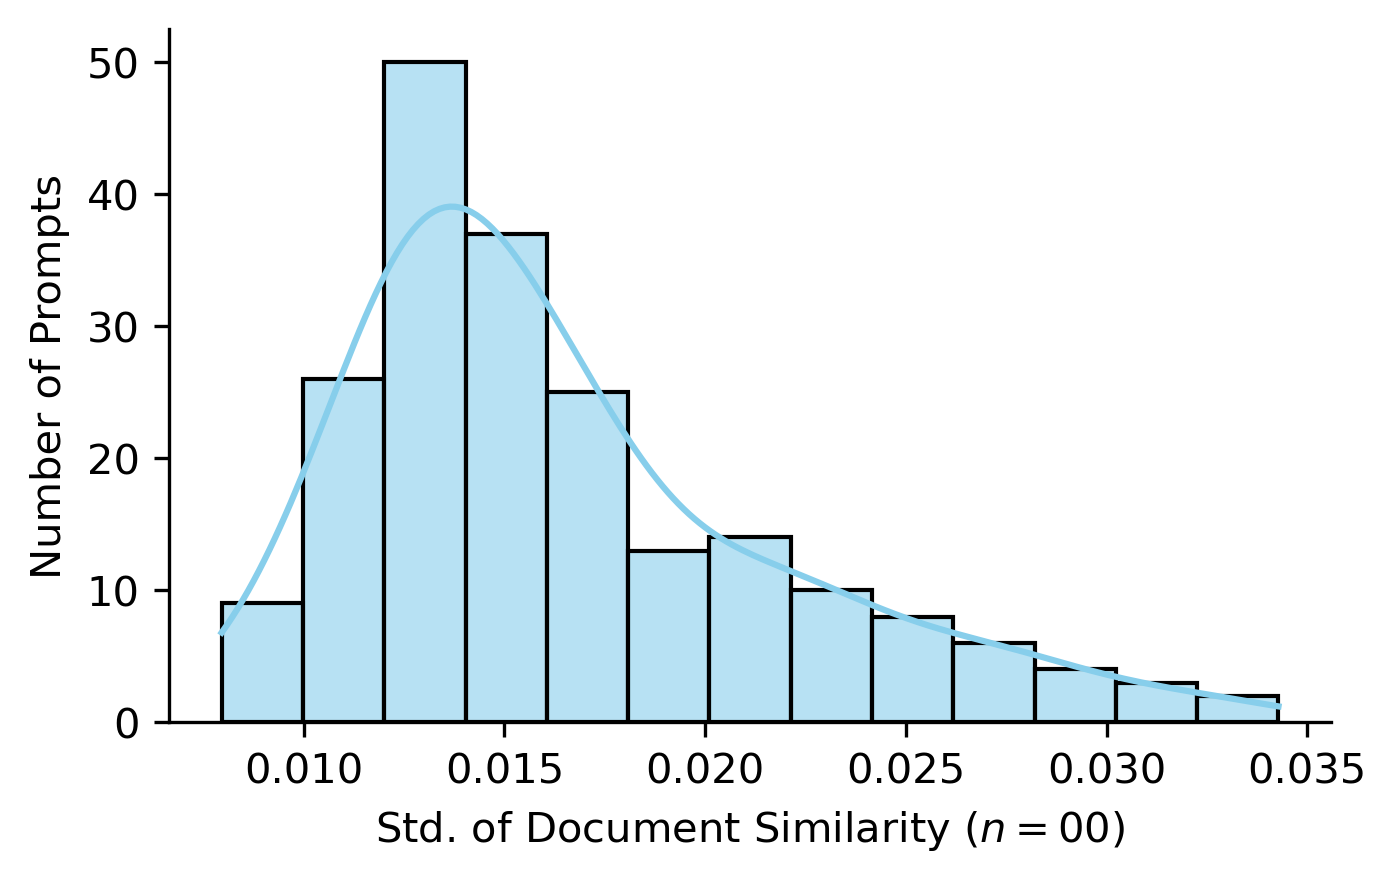

In [13]:
plt.figure(figsize=(5, 3), dpi=300)
sns.histplot(np.std(scores, axis=1), label='Prompts', kde=True, color='skyblue', alpha=0.6)
sns.despine()
plt.xlabel('Std. of Document Similarity ($n=00$)')
plt.ylabel('Number of Prompts')
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
nbins = 5
for y, c in enumerate(df.columns):
    hist, bins = np.histogram(df[c])
    print(hist, bins)
    ax.bar3d(bins[1:], y-.2, 0, .8, .4, hist)

ax.set_yticks(np.arange(len(df.columns)))
ax.set_yticklabels(df.columns)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


Text(0.5, 0, 'z')

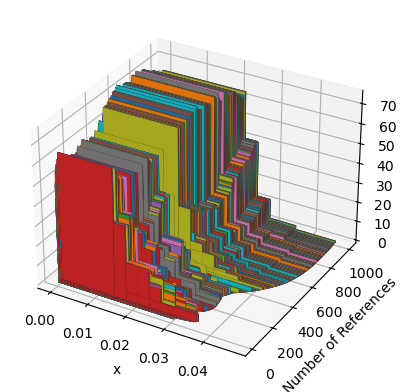

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for numDocs in range(10, 1000):
    stds = np.std(scores[:, :numDocs], axis=1)
    hist, bins = np.histogram(stds)
    ax.bar3d(0, numDocs, 0, bins[1:], 1, hist)
ax.set_xlabel('')
ax.set_ylabel('Number of References')
ax.set_zlabel('z')


In [47]:
scores.shape

(207, 100)

In [40]:
bins

array([0.00794302, 0.01058107, 0.01321911, 0.01585715, 0.01849519,
       0.02113323, 0.02377128, 0.02640932, 0.02904736, 0.0316854 ,
       0.03432345])

In [24]:
help(ax.bar3d)

Help on method bar3d in module mpl_toolkits.mplot3d.axes3d:

bar3d(x, y, z, dx, dy, dz, color=None, zsort='average', shade=True, lightsource=None, *args, data=None, **kwargs) method of mpl_toolkits.mplot3d.axes3d.Axes3D instance
    Generate a 3D barplot.
    
    This method creates three-dimensional barplot where the width,
    depth, height, and color of the bars can all be uniquely set.
    
    Parameters
    ----------
    x, y, z : array-like
        The coordinates of the anchor point of the bars.
    
    dx, dy, dz : float or array-like
        The width, depth, and height of the bars, respectively.
    
    color : sequence of colors, optional
        The color of the bars can be specified globally or
        individually. This parameter can be:
    
        - A single color, to color all bars the same color.
        - An array of colors of length N bars, to color each bar
          independently.
        - An array of colors of length 6, to color the faces of the
          

In [18]:
np.std(scores[:, numDocs], axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
scores100 = scores[:,:500]
scores100.shape

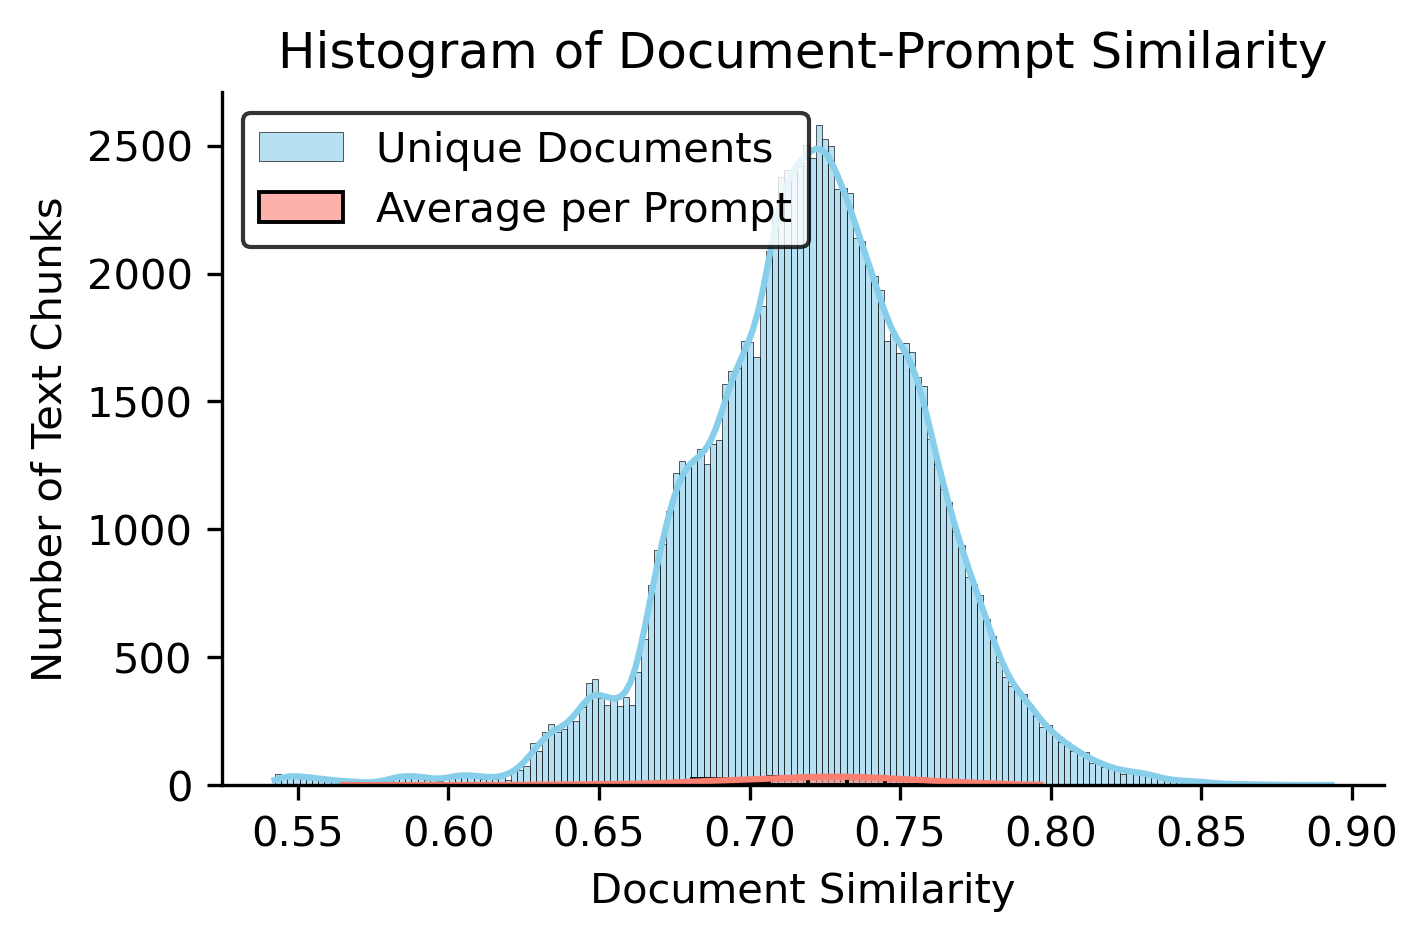

In [51]:
plt.figure(figsize=(5, 3), dpi=300)
sns.histplot(scores100.reshape(-1), label='Unique Documents', kde=True, color='skyblue', alpha=0.6)
sns.histplot(np.mean(scores100, axis=1), label='Average per Prompt', kde=True, color='salmon', alpha=0.6)

# Remove the top and right spines
sns.despine()

# Add labels and title
plt.xlabel('Document Similarity')
plt.ylabel('Number of Text Chunks')
plt.title('Histogram of Document-Prompt Similarity')

# Add a legend
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_edgecolor('black')
frame.set_facecolor('white')

plt.show()